<a href="https://colab.research.google.com/github/UnknwonD/voice_recognition/blob/main/Voice_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. 데이터 불러오기

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

data_path = '/content/drive/MyDrive/음성인식프로젝트/KsponSpeech_eval/eval_clean'
label_path = '/content/drive/MyDrive/음성인식프로젝트/KsponSpeech_scripts/eval_clean.trn'

data_list = [os.path.join(data_path, data) for data in os.listdir(data_path)]

In [ ]:
data_list[0]

'/content/drive/MyDrive/음성인식프로젝트/KsponSpeech_eval/eval_clean/KsponSpeech_E02879.pcm'

## 발화데이터 스크립트 열어보기
- 확장자 .trn

In [ ]:
with open(label_path, 'r', encoding='utf-8') as file:
    for _ in range(5):
      data = file.readline()
      print(data)

KsponSpeech_eval/eval_clean/KsponSpeech_E00001.pcm :: 어/ 일단은 억지로 과장해서 이렇게 하는 것보다 진실된 마음으로 이걸 어떻게 전달할 수 있을까 공감을 시킬 수 있을까 해서 좀

KsponSpeech_eval/eval_clean/KsponSpeech_E00002.pcm :: 혼인 신고를 또 해야 되잖아.

KsponSpeech_eval/eval_clean/KsponSpeech_E00003.pcm :: 약간 젊은 엄마 같은 느낌이야.

KsponSpeech_eval/eval_clean/KsponSpeech_E00004.pcm :: 응 근데 오늘 일단 밥 먹고 b/ 이것 저것 하다가 시간되면 뭐 가는 거고 안 되면

KsponSpeech_eval/eval_clean/KsponSpeech_E00005.pcm :: o/ 아. 우린 또 그런 거 안 하잖아. 어. 그치.



- 스크립트 발화 데이터의 경우, 상위경로에 대한 값들이 저장되어 있음. 따라서 아래와 같은 방식으로 전처리 진행
  1. ::를 기준으로 split
  2. path 값에서는 파일명만 추출
  3. 두 값을 dataframe으로 변환하여 저장


In [ ]:
label_dict = []

with open(label_path, 'r', encoding='utf-8-sig') as file:
  while True:
    line = file.readline()
    if not line: break
    target_file, script = line.split('::')
    target_file = target_file.split('/')[-1]

    tmp_dict = {"file_name": target_file.strip(),
                "script" : script.strip()}

    label_dict.append(tmp_dict)


In [ ]:
label_dict[:5]

[{'file_name': 'KsponSpeech_E00001.pcm',
  'script': '어/ 일단은 억지로 과장해서 이렇게 하는 것보다 진실된 마음으로 이걸 어떻게 전달할 수 있을까 공감을 시킬 수 있을까 해서 좀'},
 {'file_name': 'KsponSpeech_E00002.pcm', 'script': '혼인 신고를 또 해야 되잖아.'},
 {'file_name': 'KsponSpeech_E00003.pcm', 'script': '약간 젊은 엄마 같은 느낌이야.'},
 {'file_name': 'KsponSpeech_E00004.pcm',
  'script': '응 근데 오늘 일단 밥 먹고 b/ 이것 저것 하다가 시간되면 뭐 가는 거고 안 되면'},
 {'file_name': 'KsponSpeech_E00005.pcm',
  'script': 'o/ 아. 우린 또 그런 거 안 하잖아. 어. 그치.'}]

In [ ]:
import pandas as pd

df_label = pd.DataFrame(label_dict)
df_label.tail()

,file_name,script
2995,KsponSpeech_E02996.pcm,내가 가서 내가 가서 그런가 쪽수가 안 맞아서? 그래도 나는 걔 잘 생긴 애 l/
2996,KsponSpeech_E02997.pcm,그러니까 그리고 그런+ 그런 게 없어 스테이지?
2997,KsponSpeech_E02998.pcm,나한테 이거 이거 이거 이 교수 이 시간대로 꼭 넣어달라고. b/ 해가지고 해줬는데.
2998,KsponSpeech_E02999.pcm,o/ (봤지)/(봤제).
2999,KsponSpeech_E03000.pcm,그거를 해 줘.


In [ ]:
df_label.to_csv('/content/drive/MyDrive/음성인식프로젝트/KsponSpeech_scripts/eval_clean.csv', encoding='utf-8-sig')

## 음성데이터 파일 열어보기
- 확장자 .pcm
- 데이터 버퍼의 사이즈가, 2바이트 배수가 아니기 때문에, np.int16으로 로드되지 않는 문제가 발생함
- 따라서 파일을 열어보고, 직접 패딩을 통해 이를 2바이트 (16비트) 체계로 변환해주는 과정을 진행ㄹ

In [ ]:
# PCM 파일 경로
file_path = data_list[0]

# 파일 크기 확인
file_size = os.path.getsize(file_path)
print(f"파일 크기: {file_size} bytes")

# 2바이트 배수 여부 확인
if file_size % 2 != 0:
    print("경고: 파일 크기가 2바이트(16비트)의 배수가 아닙니다.")


파일 크기: 119297 bytes
경고: 파일 크기가 2바이트(16비트)의 배수가 아닙니다.


- 데이터를 읽어보는 과정에서, 바이트 버퍼가 맞지 않는 경우가 계속 발생함
- 이를 해결하기 위해 패딩을 사용해줌

- 헤더가 있는지 확인해보고자 했으나, 데이터 설명에 따로 헤더는 없다고 명시되어 있음

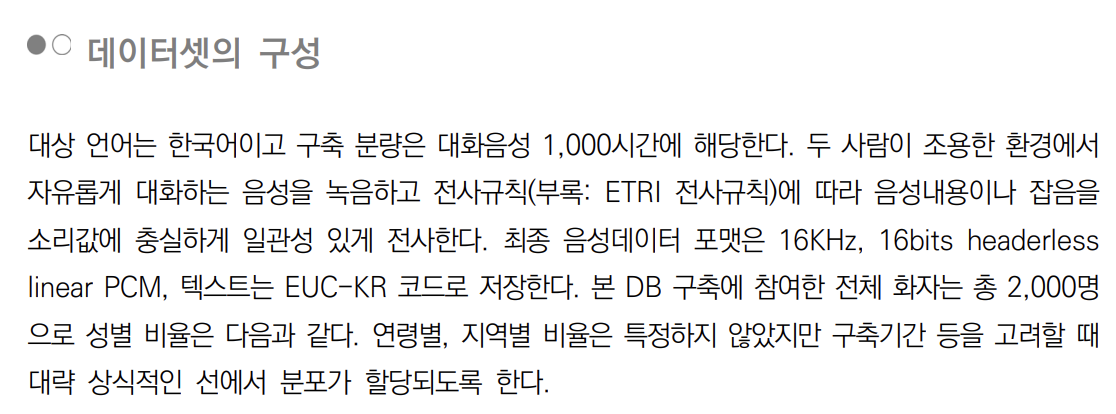

In [ ]:
import numpy as np

# 유효한 바이트 수 계산
valid_size = file_size - (file_size % 2)

# PCM 파일 읽기 (유효한 바이트까지만)
with open(file_path, 'rb') as f:
    pcm_data = f.read(valid_size)

# NumPy 배열로 변환
audio_data = np.frombuffer(pcm_data, dtype=np.int16)

print(f"유효한 데이터 길이: {len(audio_data)}")

유효한 데이터 길이: 59648


#### 최종 음성처리 프로세스 코드

파일명 : KsponSpeech_E02879.pcm
발화 내용 : 그/ 시험 아니 면접 볼 때 몇 명씩 봤는데?
파일 크기: 119297 bytes
경고: 파일 크기가 2바이트(16비트)의 배수가 아닙니다. 마지막 바이트를 무시합니다.
오디오 데이터 길이: 59648
오디오 데이터 예시: [57 50 46 44 50 46 33 35 34 26]


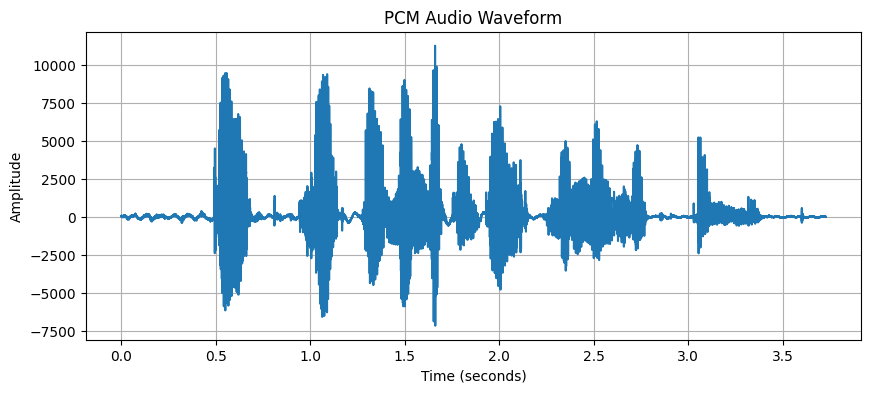

In [ ]:
import numpy as np
import os

# PCM 파일 설정
file_path = data_list[0]
sample_rate = 16000
bit_depth = 16

# 파일 크기 확인
file_size = os.path.getsize(file_path)
target_file_name = os.path.basename(file_path)
print(f"파일명 : {target_file_name}")
print(f"발화 내용 : {df_label[df_label['file_name'] == target_file_name]['script'].values[0]}")
print(f"파일 크기: {file_size} bytes")

# 파일 크기 유효성 검사
if file_size % 2 != 0:
    print("경고: 파일 크기가 2바이트(16비트)의 배수가 아닙니다. 마지막 바이트를 무시합니다.")
    valid_size = file_size - (file_size % 2)
else:
    valid_size = file_size

# PCM 파일 읽기
with open(file_path, 'rb') as f:
    pcm_data = f.read(valid_size)

# NumPy 배열로 변환
audio_data = np.frombuffer(pcm_data, dtype=np.int16)

# 데이터 확인
print(f"오디오 데이터 길이: {len(audio_data)}")
print(f"오디오 데이터 예시: {audio_data[:10]}")

# 파형 시각화
import matplotlib.pyplot as plt
time = np.linspace(0, len(audio_data) / sample_rate, num=len(audio_data))

plt.figure(figsize=(10, 4))
plt.plot(time, audio_data)
plt.title("PCM Audio Waveform")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.grid()
plt.show()


# 2. 음성데이터 살펴보기

## FFT (Fast Furier Transform)
- 음성데이터 분석에서 주로 푸리에 변환을 통해 이를 분석함
- 입력 신호를 다양한 주파수를 갖는 주기함수들로 분해하는 기법
- 음성데이터에서 노이즈 및 배경 소리로부터 필요한 소리를 추출하기 위해 사용 및 적용됨


Text(0.5, 1.0, 'Power spectrum')

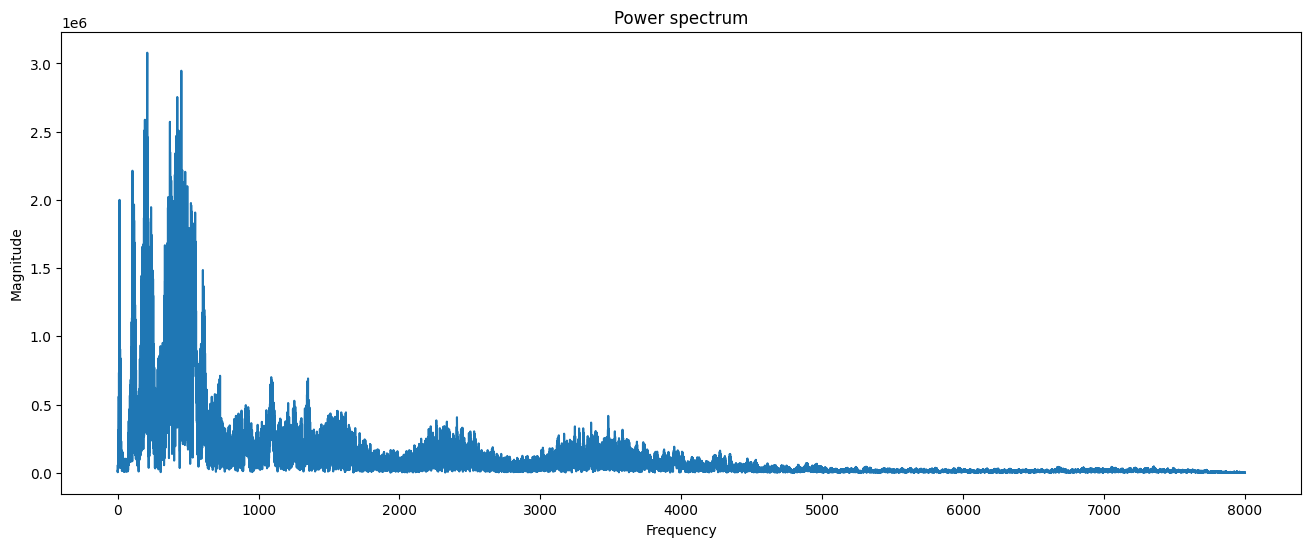

In [ ]:
audio_fft = audio_data.astype(np.float64)
fft_result = np.fft.fft(audio_fft)

magnitude = np.abs(fft_result)

# Frequency 값 만들기
f = np.linspace(0,sample_rate,len(magnitude))

# 푸리에 변환을 통과한 specturm은 대칭구조로 나와서 high frequency 부분 절반을 날려고 앞쪽 절반만 사용한다.
left_spectrum = magnitude[:int(len(magnitude)/2)]
left_f = f[:int(len(magnitude)/2)]

plt.figure(figsize=(16,6))
plt.plot(left_f, left_spectrum)
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.title("Power spectrum")

## MFCC (Mel-Frequency Cepstral Coefficients)

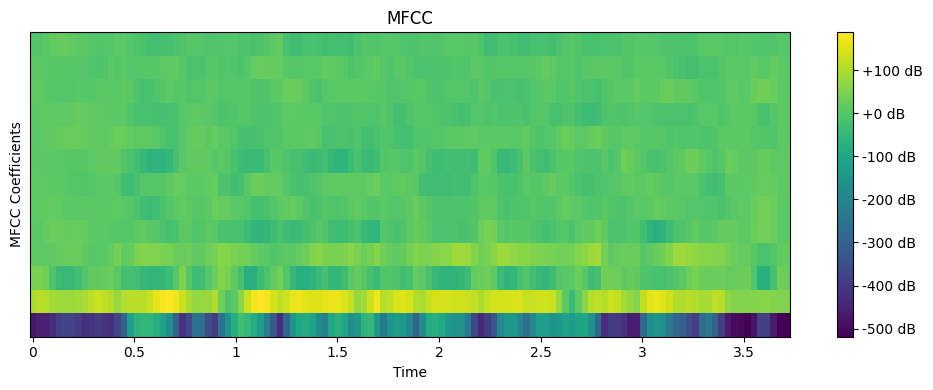

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

# PCM 데이터로부터 MFCC 생성 및 시각화
def plot_mfcc(audio_data, sample_rate):
    # MFCC 계산
    mfccs = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=13)

    # MFCC 시각화
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mfccs, x_axis='time', sr=sample_rate, cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.title('MFCC')
    plt.xlabel('Time')
    plt.ylabel('MFCC Coefficients')
    plt.tight_layout()
    plt.show()

# PCM 데이터는 float32 형식으로 변환 필요
audio_float = audio_data.astype(np.float32) / np.max(np.abs(audio_data))  # Normalize PCM data
plot_mfcc(audio_float, sample_rate)


## Mel-Spectrogram
- 주파수 도메인을 Mel Scale로 변환하여 인간의 청각 감각에 더 가깝게 나타낸 스펙트로그램

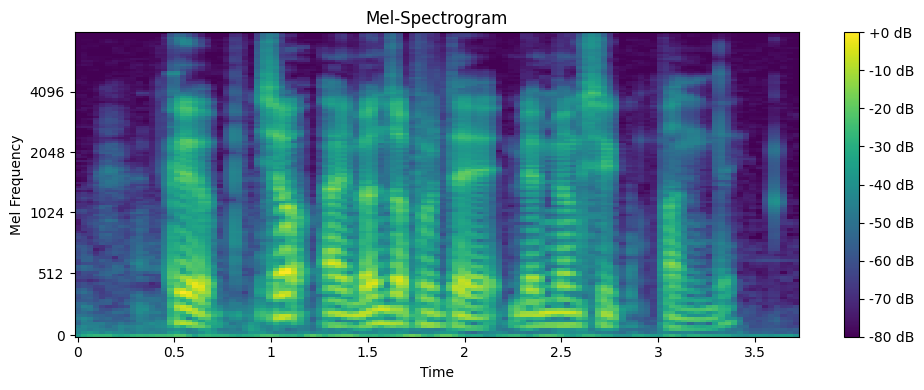

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

# PCM 데이터로부터 Mel-Spectrogram 생성 및 시각화
def plot_mel_spectrogram(audio_data, sample_rate):
    # Mel-Spectrogram 계산
    mel_spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=sample_rate, n_fft=2048, hop_length=512, n_mels=128)
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

    # Mel-Spectrogram 시각화
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel_spectrogram_db, sr=sample_rate, x_axis='time', y_axis='mel', cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel-Spectrogram')
    plt.xlabel('Time')
    plt.ylabel('Mel Frequency')
    plt.tight_layout()
    plt.show()

# PCM 데이터는 float32 형식으로 변환 필요
audio_float = audio_data.astype(np.float32) / np.max(np.abs(audio_data))  # Normalize PCM data
plot_mel_spectrogram(audio_float, sample_rate)


# 3. 음성데이터 전처리